# GSL Uruguay - January 2020

# Week - 3 | Lesson - 3

-----

# Computer Vision and Applications to Health Care

## Goals:

1. In this lesson, we will learn to work with images 
2. We start with the basics and build up quickly to solve important problems in Health Care

## Methods:
1. Convolutional Neural Networks 

---

# Covered till now:

1. Images as data
2. Basic image maniuplation - rotation, flipping, mirroing
3. Images as an array of numbers
4. Logistic regression for image classification
5. Multi-class prediction
6. Introduction to Fully Connected Neural Networks

---

# Application in health care

# Disease Detection using X-Rays

### Data Source: https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest-publicly-available-chest-x-ray-datasets-scientific-community

## Overview

1. We will try to solve a critical problem in medical diagnostics -- detecting diseases using patient scans
2. Specifically, we will focus on the chest disease, Pneumothorax, which leads to a collapsed lung
3. Our input source are chest x-ray scans of patients
4. Output is the binary label of whether the patient has the disease (1) or not (0)
5. I show a simple CNN with dropout; you should try something more expressive:
    * A deeper CNN with proper inititalization and regularization?
    * How about ResNet50 or VGG16?

## Notes:
1. The problem is challenging in many ways; think through it, discuss, and collaborate if possible
2. Don't worry if you can't solve it right now; take the learnings with you and keep coming back to it from different perspectives

---

# 0. Import modules

In [1]:
# =========================================================
# import python modules
# =========================================================

# working directory
import os

EC2 = True  # If using EC2 (for data directory/paths)

# Select path based off of local or remote
if not EC2:
    wd = "/pool001/madhavk/gsl-uruguay/health-care/"
else:
    wd = "/home/ubuntu/machine_learning_aws/"

os.chdir(wd)
from pathlib import Path

# data manipulation
import pandas as pd
import numpy as np
from numpy.random import permutation
from numpy import split
import random

# scipy images
from scipy.ndimage import rotate
from scipy.misc import imread, imshow

# models
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# parallel processing
import multiprocessing
from joblib import delayed, Parallel

# plotting
%matplotlib inline
import matplotlib.pyplot as plt

# time code
import time

# error metric
from sklearn.metrics import accuracy_score

/home/software/sloan/local/lib/py36/cryptography/hazmat/bindings/openssl/binding.py:163: CryptographyDeprecationWarning: OpenSSL version 1.0.1 is no longer supported by the OpenSSL project, please upgrade. A future version of cryptography will drop support for it.
  utils.CryptographyDeprecationWarning


In [2]:
# =========================================================
# import keras modules
# =========================================================

# working with images
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K

# keras layers
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, Input
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.models import model_from_json

# optimization routines
from keras import optimizers
from keras.utils import np_utils

# VGG19 and resnet50
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.models import Model
from keras.applications.vgg19 import VGG19
import h5py

/home/madhavk/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/software/sloan/local/lib/tensorflow/gpu/py36/1.9.0/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/software/sloan/local/lib/tensorflow/gpu/py36/1.9.0/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/software/sloan/local/lib/tensor

In [3]:
# =========================================================
# notebook options
# =========================================================

# pandas viewing options
pd.set_option('display.max_rows', 1000)

# number of cpus
cpus = multiprocessing.cpu_count()
f"Number of CPUs: {cpus}"

'Number of CPUs: 28'

----

# 0.1 Data structure

In [4]:
# ===========================================================================
# data directory for x-ray data - this should work for both local and remote
# ===========================================================================

data_dir = "data/x-pneumonia/"
print(os.listdir(data_dir))

['test', 'train', 'val', 'inceptionV3-base.json', 'inceptionV3-base.h5', 'VGG19.json', 'VGG19.h5']


In [5]:
# =========================================================
# training files
# =========================================================

train_dir = data_dir + "train/"
print(os.listdir(train_dir))

['PNEUMONIA', 'NORMAL']


In [6]:
# =========================================================
# test files
# =========================================================

test_dir = data_dir + "test/"
print(os.listdir(test_dir))

['PNEUMONIA', 'NORMAL']


In [7]:
# assign specific directories
train_dir_pos = train_dir + "PNEUMONIA/"
train_dir_neg = train_dir + "NORMAL/"

test_dir_pos = test_dir + "PNEUMONIA/"
test_dir_neg = test_dir + "NORMAL/"

In [8]:
# number of images per class

# training
print(len(os.listdir(train_dir_pos)))
print(len(os.listdir(train_dir_neg)))

# test
print(len(os.listdir(test_dir_pos)))
print(len(os.listdir(test_dir_neg)))

2707
944
390
234


----

# 1. Explore data

## 1.1. Example images

In [9]:
# structure within train directory
os.listdir(train_dir_pos)[:10]

['person63_bacteria_306.jpeg',
 'person1438_bacteria_3721.jpeg',
 'person755_bacteria_2659.jpeg',
 'person661_bacteria_2553.jpeg',
 'person1214_bacteria_3166.jpeg',
 'person1353_virus_2333.jpeg',
 'person26_bacteria_122.jpeg',
 'person890_bacteria_2814.jpeg',
 'person1514_bacteria_3964.jpeg',
 'person69_bacteria_338.jpeg']

In [10]:
# structure within train directory
os.listdir(train_dir_neg)[:5]

['NORMAL2-IM-1056-0001.jpeg',
 'NORMAL2-IM-1260-0001.jpeg',
 'IM-0656-0001-0001.jpeg',
 'NORMAL2-IM-1110-0001.jpeg',
 'IM-0757-0001.jpeg']

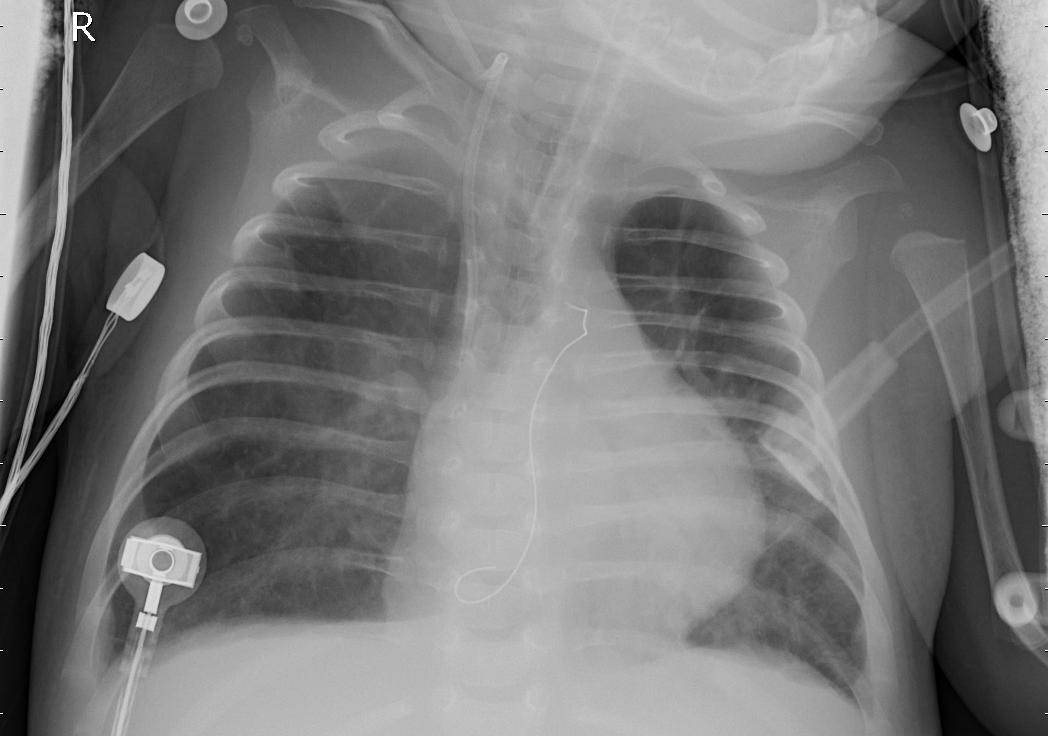

In [11]:
# positive image
i1 = load_img(train_dir_pos + os.listdir(train_dir_pos)[0])
i1

In [12]:
# image size
i1.size

(1048, 736)

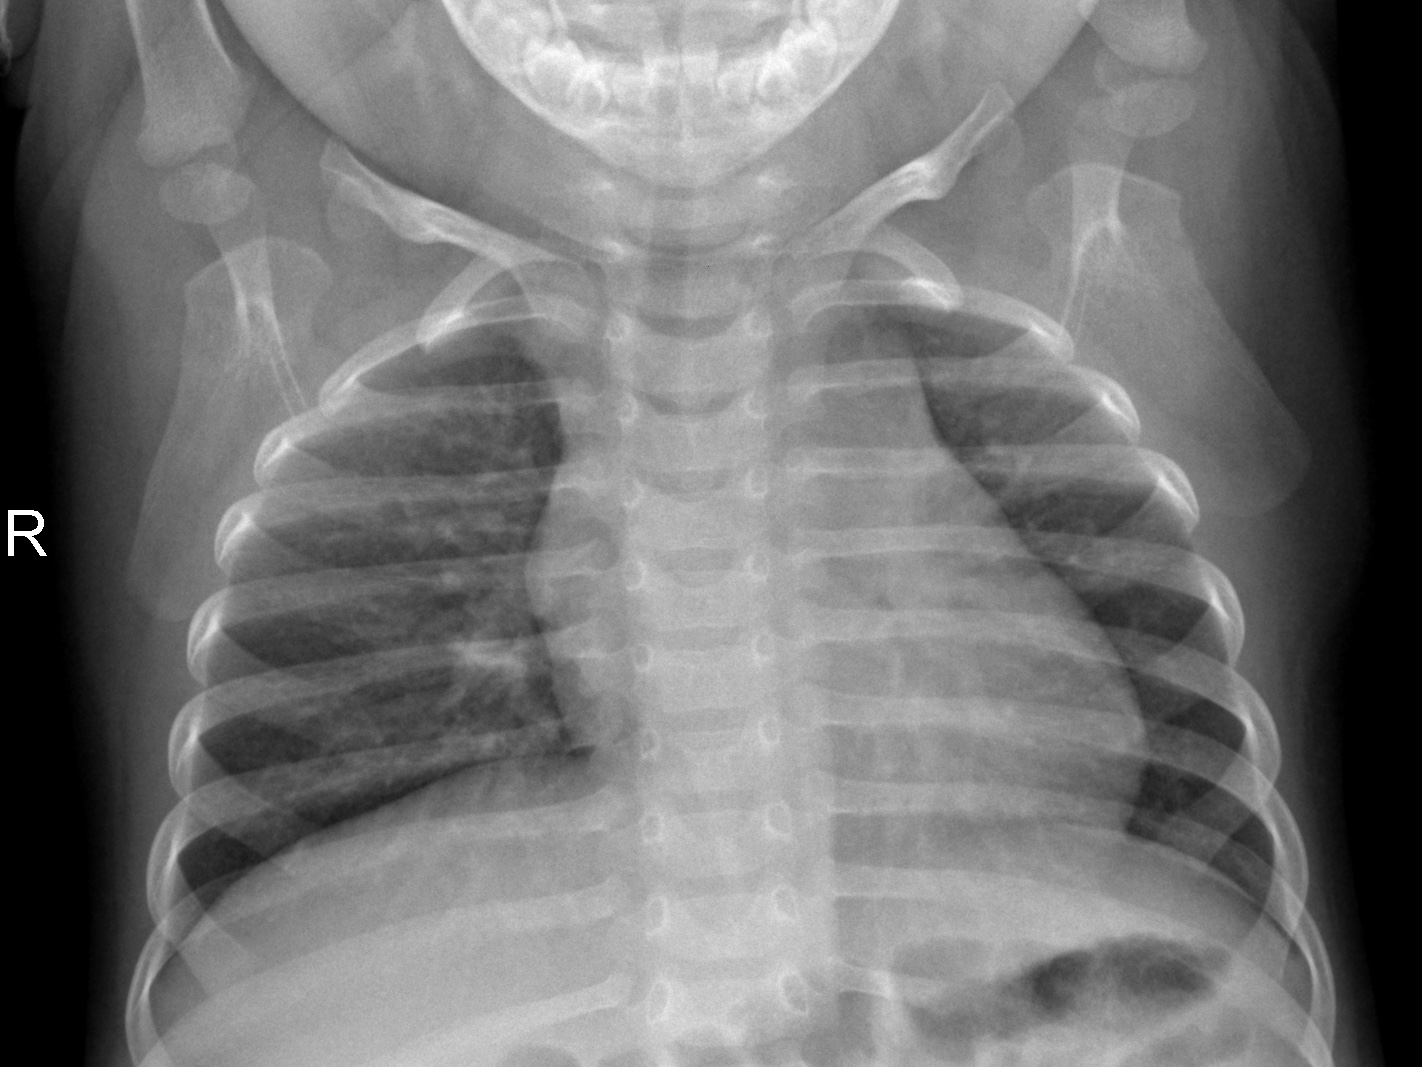

In [13]:
# example negative image
i2 = load_img(train_dir_neg + os.listdir(train_dir_neg)[0])
i2

In [14]:
# image size
i2.size

(1422, 1067)

## 1.2. Load smaller images

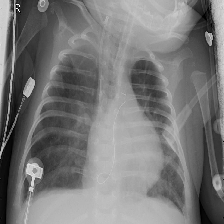

In [15]:
# example dog image
i1 = load_img(train_dir_pos + os.listdir(train_dir_pos)[0], target_size = (224, 224))
i1

In [16]:
# check size
print(i1.size)

(224, 224)


## 1.3. Explore more positive images

In [17]:
#===============================================
# plot pictures from file
#===============================================
def PicturesFromPaths(image_paths, target_size = (224, 224)):
    plt_pic = plt.figure(figsize = (14, 7))
    for i in range(len(image_paths)):
        sb_plt = plt_pic.add_subplot(1, len(image_paths), i + 1)
        sb_plt.axis("Off")
        plt.imshow(load_img(image_paths[i], target_size = target_size))

In [18]:
pos_image_paths = [train_dir_pos + x for x in os.listdir(train_dir_pos)[0:5]]
pos_image_paths

['data/x-pneumonia/train/PNEUMONIA/person63_bacteria_306.jpeg',
 'data/x-pneumonia/train/PNEUMONIA/person1438_bacteria_3721.jpeg',
 'data/x-pneumonia/train/PNEUMONIA/person755_bacteria_2659.jpeg',
 'data/x-pneumonia/train/PNEUMONIA/person661_bacteria_2553.jpeg',
 'data/x-pneumonia/train/PNEUMONIA/person1214_bacteria_3166.jpeg']

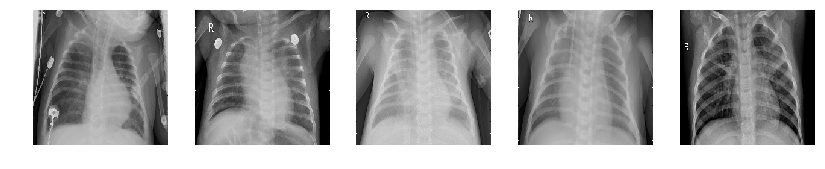

In [19]:
PicturesFromPaths(image_paths = pos_image_paths)

----

## 1.4. Try plotting the negative images

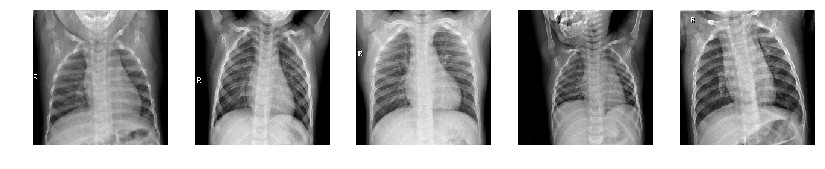

In [20]:
# PLOT NEGATIVE IMAGES HERE
neg_image_paths = [train_dir_neg + x for x in os.listdir(train_dir_neg)[0:5]]
PicturesFromPaths(image_paths = neg_image_paths)

---

## 1.5. Validation data

### Notice the structure in the training data

In [21]:
# structure within train directory
os.listdir(train_dir_pos)[:30]

['person63_bacteria_306.jpeg',
 'person1438_bacteria_3721.jpeg',
 'person755_bacteria_2659.jpeg',
 'person478_virus_975.jpeg',
 'person661_bacteria_2553.jpeg',
 'person276_bacteria_1296.jpeg',
 'person1214_bacteria_3166.jpeg',
 'person1353_virus_2333.jpeg',
 'person26_bacteria_122.jpeg',
 'person124_virus_238.jpeg',
 'person1619_bacteria_4261.jpeg',
 'person890_bacteria_2814.jpeg',
 'person1514_bacteria_3964.jpeg',
 'person1491_bacteria_3893.jpeg',
 'person69_bacteria_338.jpeg',
 'person321_bacteria_1489.jpeg',
 'person281_bacteria_1329.jpeg',
 'person688_bacteria_2584.jpeg',
 'person1598_bacteria_4197.jpeg',
 'person535_virus_1062.jpeg',
 'person1222_bacteria_3177.jpeg',
 'person581_bacteria_2392.jpeg',
 'person1233_virus_2090.jpeg',
 'person1816_bacteria_4674.jpeg',
 'person1812_bacteria_4667.jpeg',
 'person1253_virus_2129.jpeg',
 'person407_virus_811.jpeg',
 'person1415_bacteria_3629.jpeg',
 'person1261_virus_2148.jpeg',
 'person472_bacteria_2015.jpeg']

In [22]:
tmp = os.listdir(train_dir_neg)[:30]
tmp.sort()
tmp

['IM-0177-0001.jpeg',
 'IM-0207-0001.jpeg',
 'IM-0213-0001.jpeg',
 'IM-0341-0001.jpeg',
 'IM-0355-0001.jpeg',
 'IM-0388-0001.jpeg',
 'IM-0427-0001.jpeg',
 'IM-0449-0001.jpeg',
 'IM-0480-0001.jpeg',
 'IM-0494-0001.jpeg',
 'IM-0561-0001.jpeg',
 'IM-0656-0001-0001.jpeg',
 'IM-0739-0001.jpeg',
 'IM-0757-0001.jpeg',
 'NORMAL2-IM-0393-0001.jpeg',
 'NORMAL2-IM-0452-0001.jpeg',
 'NORMAL2-IM-0500-0001.jpeg',
 'NORMAL2-IM-0664-0001.jpeg',
 'NORMAL2-IM-0736-0001.jpeg',
 'NORMAL2-IM-0927-0001.jpeg',
 'NORMAL2-IM-0949-0001.jpeg',
 'NORMAL2-IM-0980-0001.jpeg',
 'NORMAL2-IM-0994-0001.jpeg',
 'NORMAL2-IM-1038-0001.jpeg',
 'NORMAL2-IM-1056-0001.jpeg',
 'NORMAL2-IM-1110-0001.jpeg',
 'NORMAL2-IM-1260-0001.jpeg',
 'NORMAL2-IM-1326-0001.jpeg',
 'NORMAL2-IM-1348-0001.jpeg',
 'NORMAL2-IM-1440-0001.jpeg']

In [23]:
# identify people in training data
pos_people = os.listdir(train_dir_pos)
print(len(pos_people))
print(pos_people[0:10])

3883
['person63_bacteria_306.jpeg', 'person1438_bacteria_3721.jpeg', 'person755_bacteria_2659.jpeg', 'person478_virus_975.jpeg', 'person661_bacteria_2553.jpeg', 'person276_bacteria_1296.jpeg', 'person1214_bacteria_3166.jpeg', 'person1353_virus_2333.jpeg', 'person26_bacteria_122.jpeg', 'person124_virus_238.jpeg']


In [24]:
# retain only person identifier
pos_people = [x.split("_")[0] for x in pos_people]
print(pos_people[0:10])

['person63', 'person1438', 'person755', 'person478', 'person661', 'person276', 'person1214', 'person1353', 'person26', 'person124']


In [25]:
# unique persons
pos_people = list(set(pos_people))
pos_people.sort()
print(len(pos_people))
print(pos_people[0:10])

1642
['person1', 'person10', 'person100', 'person1000', 'person1001', 'person1002', 'person1003', 'person1004', 'person1005', 'person1006']


In [28]:
# randomly split in train and validation
random.shuffle(pos_people)
train_ix = int(len(pos_people)*0.7)
print(train_ix)

1149


In [34]:
train_pos_list = pos_people[:train_ix]
print(len(train_pos_list))
val_pos_list = pos_people[train_ix:]
print(len(val_pos_list))

1149
493


In [35]:
# similarly create list for negative cases
neg_people = os.listdir(train_dir_neg)
print(len(neg_people))
random.shuffle(neg_people)
train_ix = int(len(neg_people)*0.7)
print(train_ix)

1349
944


In [36]:
train_neg_list = neg_people[:train_ix]
print(len(train_neg_list))
val_neg_list = neg_people[train_ix:]
print(len(val_neg_list))

944
405


In [21]:
# create directory for validation data
if not os.path.exists("data/x-pneumonia/val/"):
    os.makedirs("data/x-pneumonia/val/")
    os.makedirs("data/x-pneumonia/val/PNEUMONIA")
    os.makedirs("data/x-pneumonia/val/NORMAL")
    
val_dir = "data/x-pneumonia/val/"    
val_dir_pos = "data/x-pneumonia/val/PNEUMONIA/"
val_dir_neg = "data/x-pneumonia/val/NORMAL/"

In [47]:
# move positive files to validation folder
img_copied = 0
for img in os.listdir(train_dir_pos):
    if img.split("_")[0] in val_pos_list:
        os.rename(train_dir_pos + img, val_dir_pos + img)
        img_copied += 1
print(img_copied)

1176


In [48]:
# move negative files to validation folder
img_copied = 0
for img in os.listdir(train_dir_neg):
    if img in val_neg_list:
        os.rename(train_dir_neg + img, val_dir_neg + img)
        img_copied += 1
print(img_copied)

405


In [21]:
val_dir = "data/x-pneumonia/val/"    
val_dir_pos = "data/x-pneumonia/val/PNEUMONIA/"
val_dir_neg = "data/x-pneumonia/val/NORMAL/"

In [22]:
# number of images per class

# training
print(len(os.listdir(train_dir_pos)))
print(len(os.listdir(train_dir_neg)))

# validation
print(len(os.listdir(val_dir_pos)))
print(len(os.listdir(val_dir_neg)))

# test
print(len(os.listdir(test_dir_pos)))
print(len(os.listdir(test_dir_neg)))

2707
944
1176
405
390
234


----

# 2. Data preparation

## Thoughts:
1. Define image input tensor size
    * What image size should you use?
    * Will a bigger image necessarily provide a better model?
    * What impact will it have on the training time?
2. Create train and test image generator
    * Do you need data augementation? If yes, then what kind?
3. Which architecture can you use and which one should you use?
    * Transfer learning?
    * Are models trained on imagenet of any use here?
4. What about the loss function? 
    * The problem is asymmetric and the risk is lop-sided
    * We may want to have more false positives rather than false negatives!



In [23]:
# =========================================================
# pre-defined parameters
# =========================================================
image_width = 256
image_height = 256
image_size = (image_width, image_height)
batch_size = 32
num_epochs = 2

In [24]:
# =========================================================
# pre-defined parameters
# =========================================================

if K.image_data_format() == 'channels_first':
    input_shape = (3, image_width, image_height)
else:
    input_shape = (image_width, image_height, 3)

In [33]:
# =========================================================
# image batch generator
# =========================================================

train_datagen = ImageDataGenerator(rescale = 1./255) # all options disabled
test_datagen = ImageDataGenerator(rescale = 1./255)

In [34]:
# =========================================================
# read train in batches
# =========================================================

train_generator = train_datagen.flow_from_directory(directory = train_dir, 
                                                    target_size = image_size, 
                                                    batch_size = batch_size,
                                                    shuffle = True,
                                                    class_mode = "binary")

Found 3651 images belonging to 2 classes.


In [35]:
train_generator.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [36]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [37]:
# =========================================================
# read validation in batches
# =========================================================

val_generator = test_datagen.flow_from_directory(directory = val_dir, 
                                                    target_size = image_size, 
                                                    batch_size = batch_size,
                                                    shuffle = False,
                                                    class_mode = "binary")

Found 1581 images belonging to 2 classes.


In [38]:
# =========================================================
# read test in batches
# =========================================================

test_generator = test_datagen.flow_from_directory(directory = test_dir, 
                                                    target_size = image_size, 
                                                    batch_size = batch_size,
                                                    shuffle = False,
                                                    class_mode = "binary")

Found 624 images belonging to 2 classes.


In [39]:
test_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

----

# 3. Example CNN with Dropout

In [40]:
# =========================================================
# define model
# =========================================================

## 1 - convolution block
cnn_1 = Sequential()
cnn_1.add(Conv2D(128, (3, 3), input_shape = input_shape))
cnn_1.add(Activation("relu"))
cnn_1.add(MaxPooling2D(pool_size = (2, 2)))

## 2 - convolution block
cnn_1.add(Conv2D(64, (3, 3)))
cnn_1.add(Activation("relu"))
cnn_1.add(MaxPooling2D(pool_size=(2, 2)))

## 3 - convolution block
cnn_1.add(Conv2D(32, (3, 3)))
cnn_1.add(Activation("relu"))
cnn_1.add(MaxPooling2D(pool_size=(2, 2)))

## fully connected end
cnn_1.add(Flatten())
cnn_1.add(Dense(128))
cnn_1.add(Activation("relu"))
cnn_1.add(Dropout(0.25))
cnn_1.add(Dense(1))
cnn_1.add(Activation("sigmoid"))

# =========================================================
# compile model
# =========================================================

cnn_1.compile(loss = "binary_crossentropy",
              optimizer = optimizers.Adam(),
              metrics = ["acc"])

In [41]:
# =========================================================
# train model
# =========================================================

t0 = time.time()
cnn_1.fit_generator(train_generator,
                    epochs = 5,
                    validation_data = val_generator,
                    workers = cpus, 
                    use_multiprocessing = True)
t1 = time.time()

print("-----------------")
print(f"Time taken: {t1 - t0}")

Epoch 1/5
115/115 [==============================] - 46s 401ms/step - loss: 0.2974 - acc: 0.8691 - val_loss: 0.5480 - val_acc: 0.7324
Epoch 2/5
115/115 [==============================] - 43s 375ms/step - loss: 0.1875 - acc: 0.9285 - val_loss: 0.1346 - val_acc: 0.9500
Epoch 3/5
115/115 [==============================] - 43s 377ms/step - loss: 0.1043 - acc: 0.9647 - val_loss: 0.0991 - val_acc: 0.9652
Epoch 4/5
115/115 [==============================] - 43s 375ms/step - loss: 0.0805 - acc: 0.9712 - val_loss: 0.0741 - val_acc: 0.9741
Epoch 5/5
115/115 [==============================] - 44s 379ms/step - loss: 0.0648 - acc: 0.9745 - val_loss: 0.0683 - val_acc: 0.9753
-----------------
Time taken: 219.69422602653503


In [42]:
# =================================================
# predict on test
# =================================================

# predict on batch
cnn_1_score = cnn_1.evaluate_generator(test_generator,
                                      workers = cpus,
                                      use_multiprocessing = True)
cnn_1_score[1]

0.7387820512820513

----

## We can do better than this

### Redefining batch generators

In [43]:
# =========================================================
# image batch generator
# =========================================================

# train generator
train_datagen = ImageDataGenerator(rescale = 1./255, 
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# test generator
test_datagen = ImageDataGenerator(rescale = 1./255)

# data paths for the generators
train_generator = train_datagen.flow_from_directory(directory = train_dir, 
                                                    target_size = image_size, 
                                                    batch_size = batch_size,
                                                    shuffle = True,
                                                    class_mode = "binary")

val_generator = test_datagen.flow_from_directory(directory = val_dir, 
                                                    target_size = image_size, 
                                                    batch_size = batch_size,
                                                    shuffle = False,
                                                    class_mode = "binary")

test_generator = test_datagen.flow_from_directory(directory = test_dir, 
                                                    target_size = image_size, 
                                                    batch_size = batch_size,
                                                    shuffle = False,
                                                    class_mode = "binary")

Found 3651 images belonging to 2 classes.
Found 1581 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [44]:
# =========================================================
# define model
# =========================================================

## 1 - convolution block
cnn_1 = Sequential()
cnn_1.add(Conv2D(128, (3, 3), input_shape = input_shape))
cnn_1.add(Activation("relu"))
cnn_1.add(MaxPooling2D(pool_size = (2, 2)))

## 2 - convolution block
cnn_1.add(Conv2D(64, (3, 3)))
cnn_1.add(Activation("relu"))
cnn_1.add(MaxPooling2D(pool_size=(2, 2)))

## 3 - convolution block
cnn_1.add(Conv2D(32, (3, 3)))
cnn_1.add(Activation("relu"))
cnn_1.add(MaxPooling2D(pool_size=(2, 2)))

## fully connected end
cnn_1.add(Flatten())
cnn_1.add(Dense(128))
cnn_1.add(Activation("relu"))
cnn_1.add(Dropout(0.25))
cnn_1.add(Dense(1))
cnn_1.add(Activation("sigmoid"))

# =========================================================
# re-compile model
# =========================================================

cnn_1.compile(loss = "binary_crossentropy",
              optimizer = optimizers.Adam(),
              metrics = ["acc"])

In [45]:
# =========================================================
# train model
# =========================================================

t0 = time.time()
cnn_1.fit_generator(train_generator,
                    epochs = 5,
                    validation_data = val_generator,
                    workers = cpus, 
                    use_multiprocessing = True)
t1 = time.time()

print("-----------------")
print(f"Time taken: {t1 - t0}")

Epoch 1/5
115/115 [==============================] - 46s 402ms/step - loss: 0.4725 - acc: 0.7784 - val_loss: 0.3312 - val_acc: 0.8659
Epoch 2/5
115/115 [==============================] - 43s 376ms/step - loss: 0.3139 - acc: 0.8694 - val_loss: 0.2130 - val_acc: 0.9121
Epoch 3/5
115/115 [==============================] - 43s 378ms/step - loss: 0.2784 - acc: 0.8894 - val_loss: 0.2252 - val_acc: 0.9127
Epoch 4/5
115/115 [==============================] - 44s 379ms/step - loss: 0.2328 - acc: 0.9052 - val_loss: 0.1629 - val_acc: 0.9355
Epoch 5/5
115/115 [==============================] - 43s 376ms/step - loss: 0.2342 - acc: 0.9065 - val_loss: 0.1777 - val_acc: 0.9317
-----------------
Time taken: 220.21303176879883


In [46]:
# =================================================
# predict on test
# =================================================

# predict on batch
cnn_1_score = cnn_1.evaluate_generator(test_generator,
                                      workers = cpus,
                                      use_multiprocessing = True)
cnn_1_score[1]

0.75

## What does 73% accuracy mean?

In [156]:
# generate predictions
cnn_1_pred = cnn_1.predict_generator(test_generator,
                                           workers = cpus,
                                           use_multiprocessing = True,
                                           verbose = True)
# convert to binary label
cnn_1_pred_label = [0 if x < 0.5 else 1 for x in list(cnn_1_pred)]

# true labels
labels = [0]*len(os.listdir(test_dir_neg)) + [1]*len(os.listdir(test_dir_pos))
accuracy_score(y_true = labels, y_pred = cnn_1_pred_label)

20/20 [==============================] - 4s 212ms/step


0.75

In [178]:
# get the confusion matrix
CM = confusion_matrix(y_true = labels, y_pred = cnn_1_pred_label)
CM

array([[ 80, 154],
       [  2, 388]])

In [161]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[ 80 154]
 [  2 388]]


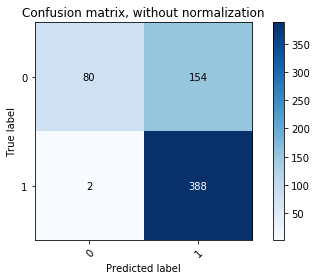

In [169]:
plot_confusion_matrix(y_pred=cnn_1_pred_label, y_true=labels, classes = np.array([0, 1]))

In [171]:
# precision
precision_score(y_true = labels, y_pred = cnn_1_pred_label)

0.7158671586715867

In [172]:
# recall
recall_score(y_true = labels, y_pred = cnn_1_pred_label)

0.9948717948717949

In [173]:
f1_score(y_true = labels, y_pred = cnn_1_pred_label)

0.8326180257510729

In [177]:
print(classification_report(y_true = labels, y_pred = cnn_1_pred_label))

             precision    recall  f1-score   support

          0       0.98      0.34      0.51       234
          1       0.72      0.99      0.83       390

avg / total       0.81      0.75      0.71       624



---

## Let's try a bigger/better model

In [29]:
# =========================================================
# image batch generator
# =========================================================

# train generator
train_datagen = ImageDataGenerator(rescale = 1./255, 
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# test generator
test_datagen = ImageDataGenerator(rescale = 1./255)

# data paths for the generators
train_generator = train_datagen.flow_from_directory(directory = train_dir, 
                                                    target_size = image_size, 
                                                    batch_size = batch_size,
                                                    shuffle = True,
                                                    class_mode = "binary")

val_generator = test_datagen.flow_from_directory(directory = val_dir, 
                                                    target_size = image_size, 
                                                    batch_size = batch_size,
                                                    shuffle = False,
                                                    class_mode = "binary")

test_generator = test_datagen.flow_from_directory(directory = test_dir, 
                                                    target_size = image_size, 
                                                    batch_size = batch_size,
                                                    shuffle = False,
                                                    class_mode = "binary")

Found 3651 images belonging to 2 classes.
Found 1581 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [200]:
# =========================================================
# define model
# =========================================================

## 1 - convolution block
cnn_1 = Sequential()
cnn_1.add(Conv2D(32, (3, 3), input_shape = input_shape))
cnn_1.add(Activation("relu"))
cnn_1.add(MaxPooling2D(pool_size = (2, 2)))

## 2 - convolution block
cnn_1.add(Conv2D(32, (3, 3)))
cnn_1.add(Activation("relu"))
cnn_1.add(MaxPooling2D(pool_size=(2, 2)))

## 3 - convolution block
cnn_1.add(Conv2D(64, (3, 3)))
cnn_1.add(Activation("relu"))
cnn_1.add(MaxPooling2D(pool_size=(2, 2)))

## fully connected end
cnn_1.add(Flatten())
cnn_1.add(Dense(128))
cnn_1.add(Activation("relu"))
cnn_1.add(Dropout(0.5))
cnn_1.add(Dense(64))
cnn_1.add(Activation("relu"))
cnn_1.add(Dropout(0.25))
cnn_1.add(Dense(1))
cnn_1.add(Activation("sigmoid"))

# =========================================================
# re-compile model
# =========================================================

cnn_1.compile(loss = "binary_crossentropy",
              optimizer = optimizers.Adam(),
              metrics = ["acc"])

In [201]:
# =========================================================
# train model
# =========================================================

t0 = time.time()
cnn_1.fit_generator(train_generator,
                    epochs = 5,
                    validation_data = val_generator,
                    workers = cpus, 
                    use_multiprocessing = True)
t1 = time.time()

print("-----------------")
print(f"Time taken: {t1 - t0}")

Epoch 1/5
115/115 [==============================] - 24s 212ms/step - loss: 0.4906 - acc: 0.7742 - val_loss: 0.2336 - val_acc: 0.9064
Epoch 2/5
115/115 [==============================] - 21s 180ms/step - loss: 0.3248 - acc: 0.8566 - val_loss: 0.2204 - val_acc: 0.9026
Epoch 3/5
115/115 [==============================] - 21s 184ms/step - loss: 0.2735 - acc: 0.8897 - val_loss: 0.1800 - val_acc: 0.9247
Epoch 4/5
115/115 [==============================] - 20s 174ms/step - loss: 0.2707 - acc: 0.8865 - val_loss: 0.1823 - val_acc: 0.9361
Epoch 5/5
115/115 [==============================] - 21s 181ms/step - loss: 0.2484 - acc: 0.9030 - val_loss: 0.1559 - val_acc: 0.9393
-----------------
Time taken: 107.93227982521057


In [202]:
# generate predictions
cnn_1_pred = cnn_1.predict_generator(test_generator,
                                           workers = cpus,
                                           use_multiprocessing = True,
                                           verbose = True)
# convert to binary label
cnn_1_pred_label = [0 if x < 0.5 else 1 for x in list(cnn_1_pred)]

# true labels
labels = [0]*len(os.listdir(test_dir_neg)) + [1]*len(os.listdir(test_dir_pos))
accuracy_score(y_true = labels, y_pred = cnn_1_pred_label)

20/20 [==============================] - 3s 162ms/step


0.7852564102564102

In [203]:
print(classification_report(y_true = labels, y_pred = cnn_1_pred_label))

             precision    recall  f1-score   support

          0       0.95      0.45      0.61       234
          1       0.75      0.99      0.85       390

avg / total       0.83      0.79      0.76       624



----

## Visualizaing CNN Activations

1. To visualizae CNN activations we need the outputs from each layer
2. Using the outputs, we will recontruct the image

In [67]:
cnn_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 254, 254, 128)     3584      
_________________________________________________________________
activation_11 (Activation)   (None, 254, 254, 128)     0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 127, 127, 128)     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 125, 125, 64)      73792     
_________________________________________________________________
activation_12 (Activation)   (None, 125, 125, 64)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 60, 60, 32)        18464     
__________

In [70]:
# number of layers in our model
len(cnn_1.layers)

15

In [73]:
# consider the first 10 layers
cnn_layer_output = [layer.output for layer in cnn_1.layers[:10]] 
cnn_layer_output

[<tf.Tensor 'conv2d_7/BiasAdd:0' shape=(?, 254, 254, 128) dtype=float32>,
 <tf.Tensor 'activation_11/Relu:0' shape=(?, 254, 254, 128) dtype=float32>,
 <tf.Tensor 'max_pooling2d_7/MaxPool:0' shape=(?, 127, 127, 128) dtype=float32>,
 <tf.Tensor 'conv2d_8/BiasAdd:0' shape=(?, 125, 125, 64) dtype=float32>,
 <tf.Tensor 'activation_12/Relu:0' shape=(?, 125, 125, 64) dtype=float32>,
 <tf.Tensor 'max_pooling2d_8/MaxPool:0' shape=(?, 62, 62, 64) dtype=float32>,
 <tf.Tensor 'conv2d_9/BiasAdd:0' shape=(?, 60, 60, 32) dtype=float32>,
 <tf.Tensor 'activation_13/Relu:0' shape=(?, 60, 60, 32) dtype=float32>,
 <tf.Tensor 'max_pooling2d_9/MaxPool:0' shape=(?, 30, 30, 32) dtype=float32>,
 <tf.Tensor 'flatten_3/Reshape:0' shape=(?, ?) dtype=float32>]

---

1. To get the activations we need to inititate a keras model
2. The models needs an image tensor as input and will give the activations as output

In [75]:
activation_model = models.Model(inputs = cnn_1.input, outputs = cnn_layer_output) 
activation_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7_input (InputLayer)  (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 254, 254, 128)     3584      
_________________________________________________________________
activation_11 (Activation)   (None, 254, 254, 128)     0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 127, 127, 128)     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 125, 125, 64)      73792     
_________________________________________________________________
activation_12 (Activation)   (None, 125, 125, 64)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 62, 62, 64)        0         
__________

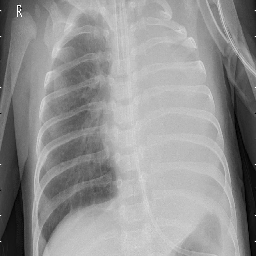

In [80]:
# load sample image 
test_image = load_img(train_dir_pos + os.listdir(train_dir_pos)[20], 
                      target_size = (256, 256)) # ensure shape compliance with model
test_image

In [81]:
test_image_tensor = image.img_to_array(test_image)
test_image_tensor = np.expand_dims(test_image_tensor, axis=0)
test_image_tensor /= 255.
print(test_image_tensor.shape)

(1, 256, 256, 3)


In [82]:
test_image_tensor

array([[[[0.11372549, 0.11372549, 0.11372549],
         [0.13725491, 0.13725491, 0.13725491],
         [0.14509805, 0.14509805, 0.14509805],
         ...,
         [0.14117648, 0.14117648, 0.14117648],
         [0.11764706, 0.11764706, 0.11764706],
         [0.08627451, 0.08627451, 0.08627451]],

        [[0.11372549, 0.11372549, 0.11372549],
         [0.13725491, 0.13725491, 0.13725491],
         [0.14509805, 0.14509805, 0.14509805],
         ...,
         [0.14117648, 0.14117648, 0.14117648],
         [0.11372549, 0.11372549, 0.11372549],
         [0.08627451, 0.08627451, 0.08627451]],

        [[0.11372549, 0.11372549, 0.11372549],
         [0.13725491, 0.13725491, 0.13725491],
         [0.14509805, 0.14509805, 0.14509805],
         ...,
         [0.13725491, 0.13725491, 0.13725491],
         [0.1254902 , 0.1254902 , 0.1254902 ],
         [0.10588235, 0.10588235, 0.10588235]],

        ...,

        [[0.11764706, 0.11764706, 0.11764706],
         [0.09411765, 0.09411765, 0.09411765]

In [83]:
activations = activation_model.predict(test_image_tensor) 
len(activations)

10

In [84]:
activations

[array([[[[-0.06806383, -0.00910032, -0.03928651, ..., -0.05536405,
           -0.00686761, -0.0238313 ],
          [-0.07675102, -0.01324841, -0.0360585 , ..., -0.06073801,
           -0.0068806 , -0.03064796],
          [-0.08076712, -0.0159202 , -0.03550644, ..., -0.06236606,
           -0.00790648, -0.02744905],
          ...,
          [-0.08220939, -0.03024758, -0.03606692, ..., -0.05348884,
           -0.00438355, -0.03388685],
          [-0.07456748, -0.02927656, -0.03660155, ..., -0.04760008,
           -0.00186678, -0.03315149],
          [-0.06496466, -0.02392   , -0.04081814, ..., -0.04063043,
           -0.00214231, -0.02850041]],
 
         [[-0.0695148 , -0.00843387, -0.03998845, ..., -0.05555347,
           -0.00810437, -0.02421485],
          [-0.07673071, -0.01341709, -0.0363366 , ..., -0.05985632,
           -0.00721996, -0.03044088],
          [-0.08236428, -0.01500397, -0.0354071 , ..., -0.06514392,
           -0.0086674 , -0.02992672],
          ...,
          [-0

In [93]:
print(activations[0].shape)
print(cnn_1.layers[0].output)

(1, 254, 254, 128)
Tensor("conv2d_7/BiasAdd:0", shape=(?, 254, 254, 128), dtype=float32)


In [88]:
print(activations[5].shape)
print(cnn_1.layers[5].output)

(1, 62, 62, 64)
Tensor("max_pooling2d_8/MaxPool:0", shape=(?, 62, 62, 64), dtype=float32)


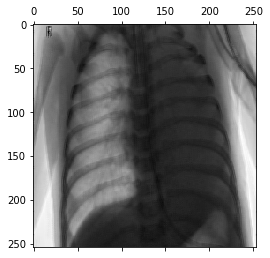

In [102]:
# activations for 1st layer
plt.matshow(activations[0][0, :, :, 0], cmap = "gray");

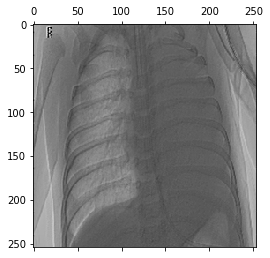

In [103]:
plt.matshow(activations[0][0, :, :, 1], cmap = "gray");

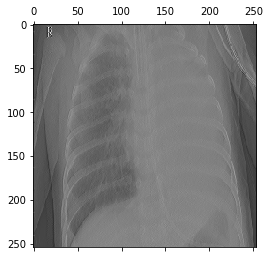

In [104]:
plt.matshow(activations[0][0, :, :, 88], cmap = "gray");

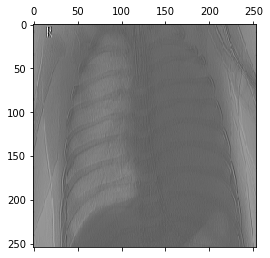

In [107]:
plt.matshow(activations[0][0, :, :, 127], cmap = "gray");

In [142]:
def CnnViz(activations, layer_number):
    nrows = 4
    ncols = 6
    layer_activation = activations[layer_number]
    ix = 0
    fig, ax = plt.subplots(nrows, ncols, figsize = (nrows*4, ncols*2))
    for row in range(0, nrows):
        for col in range(0, ncols):
            ax[row][col].imshow(layer_activation[0, :, :, ix], cmap = "viridis")
            ix += 1

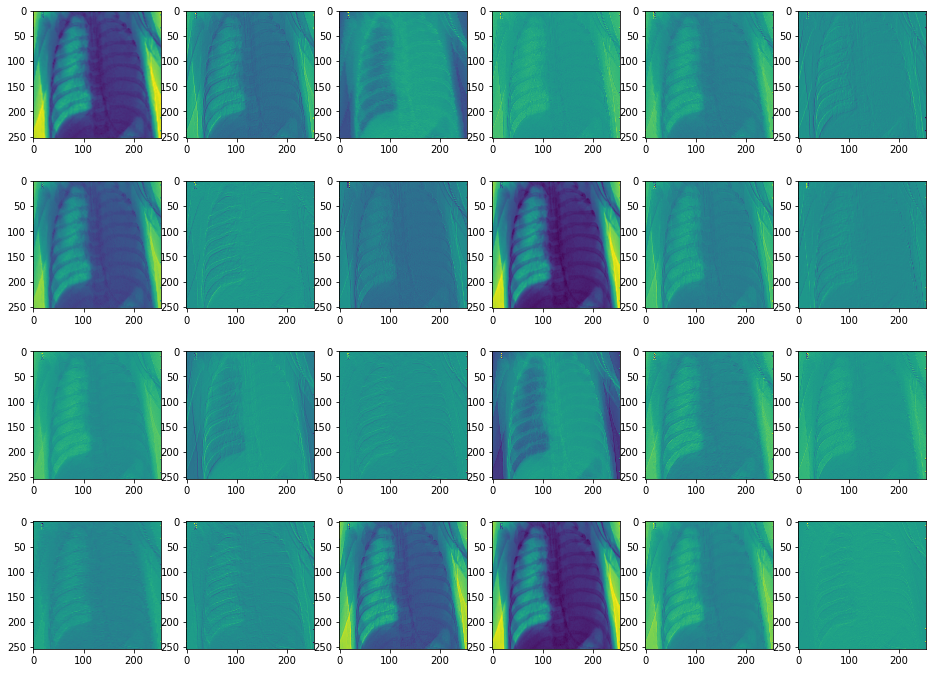

In [143]:
# visualizations for the first layer
CnnViz(activations= activations, layer_number = 0)

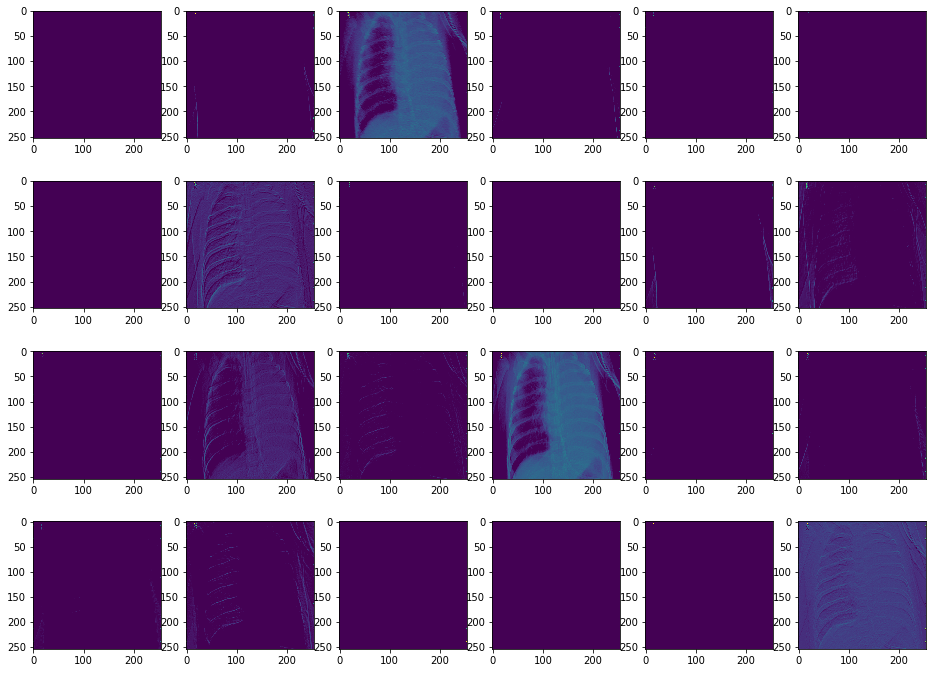

In [144]:
# visualizations for the second layer - relu
CnnViz(activations= activations, layer_number = 1)

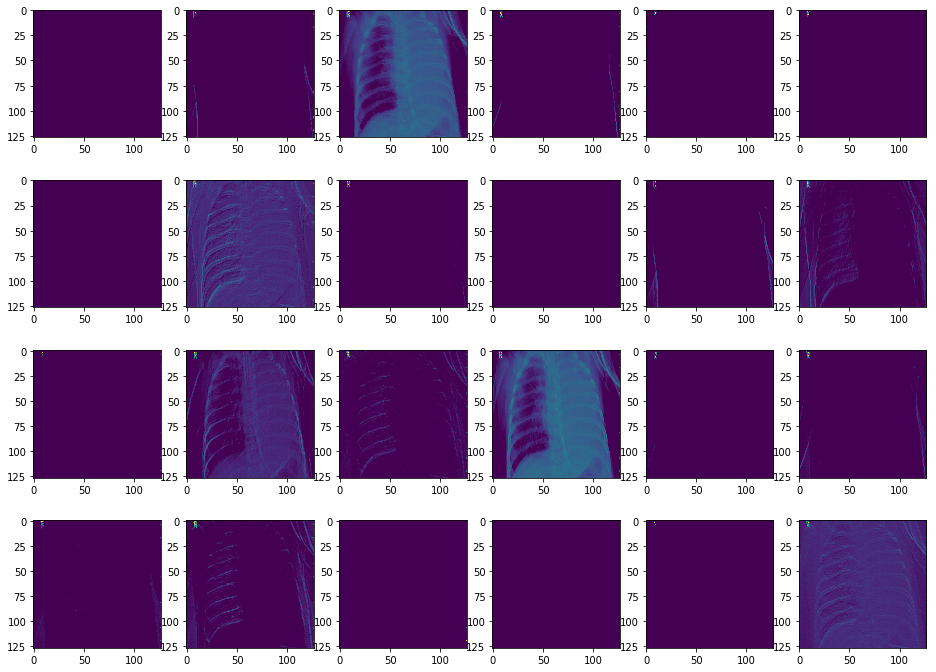

In [145]:
# visualizations for the third layer - max pool
CnnViz(activations= activations, layer_number = 2)

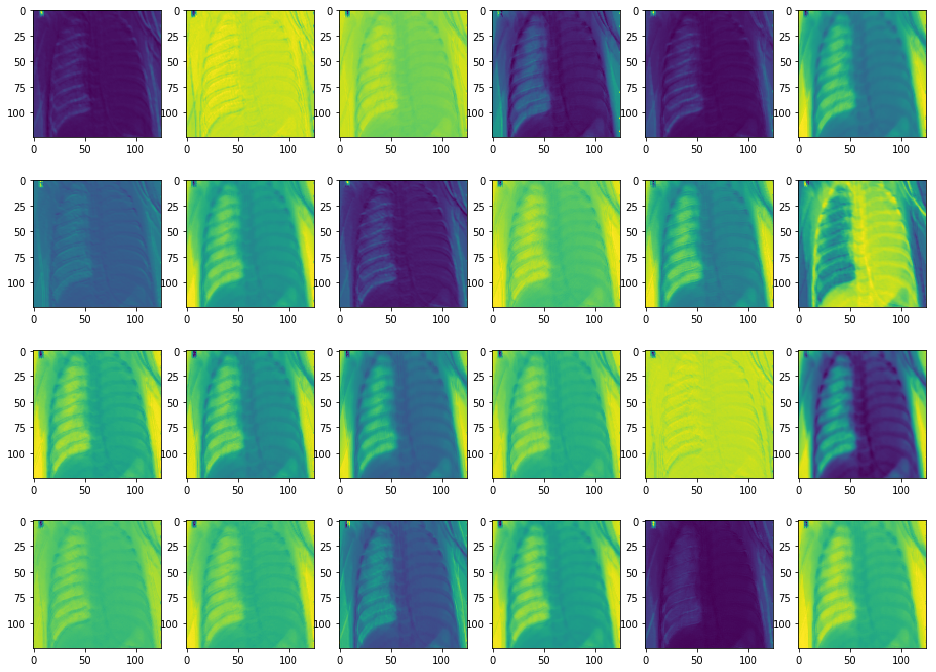

In [146]:
# visualizations for the second layer
CnnViz(activations= activations, layer_number = 3)

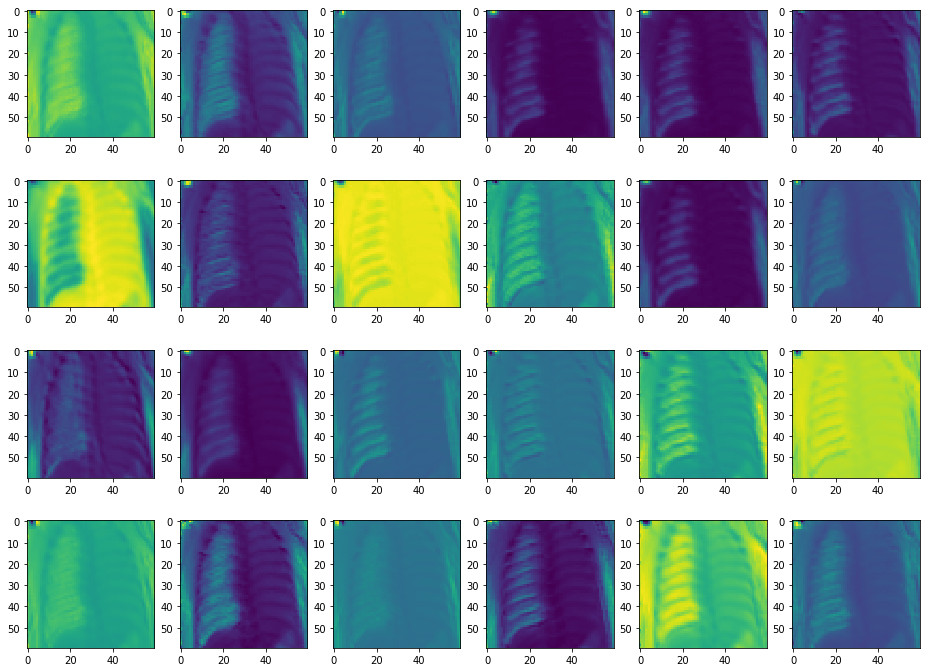

In [147]:
# visualizations for the last convolutional layer
CnnViz(activations= activations, layer_number = 6)

### Joint visualization

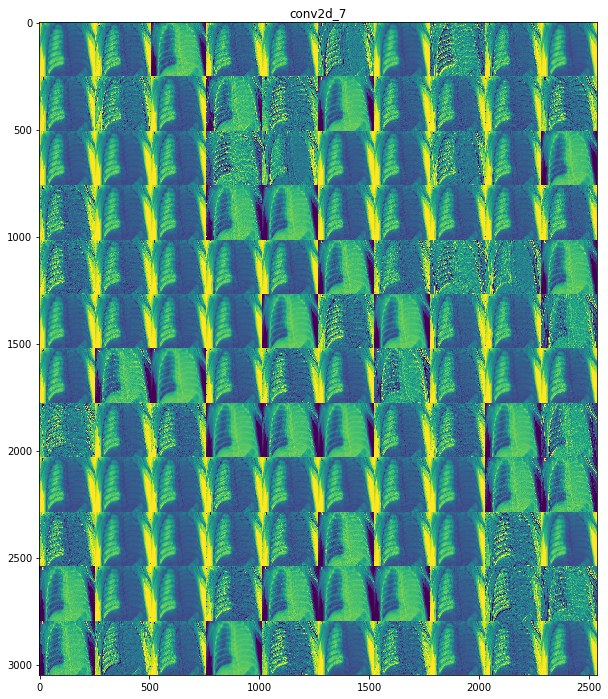

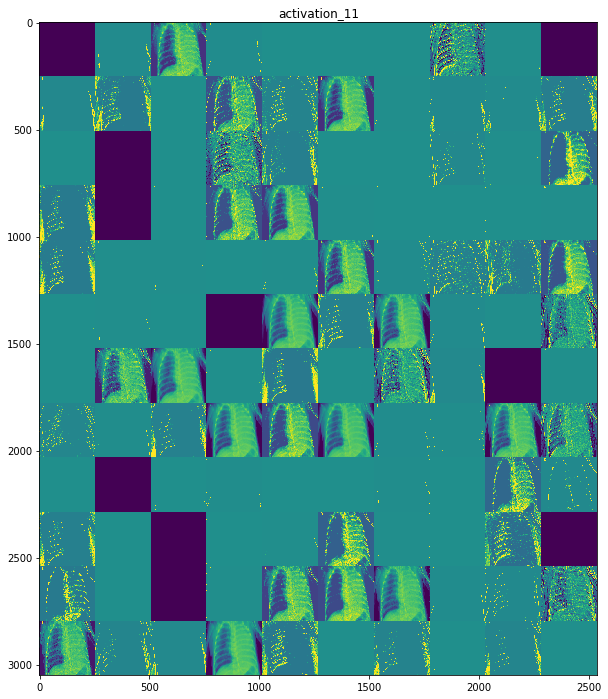

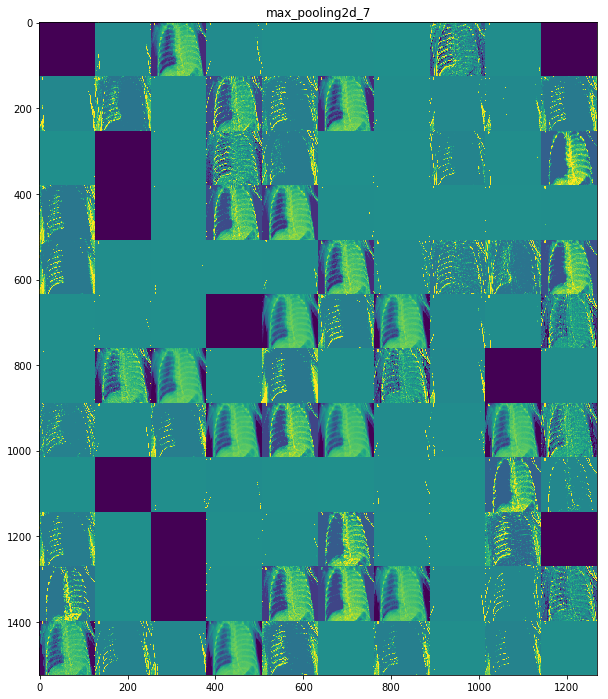

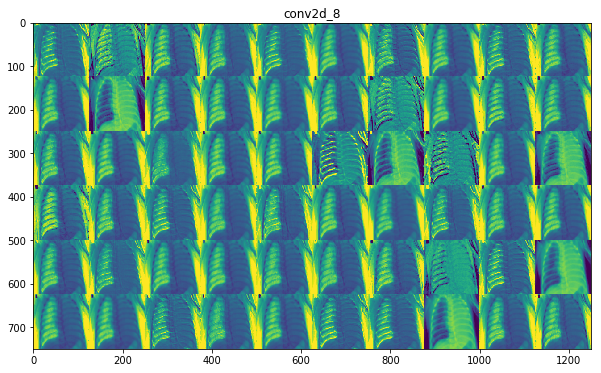

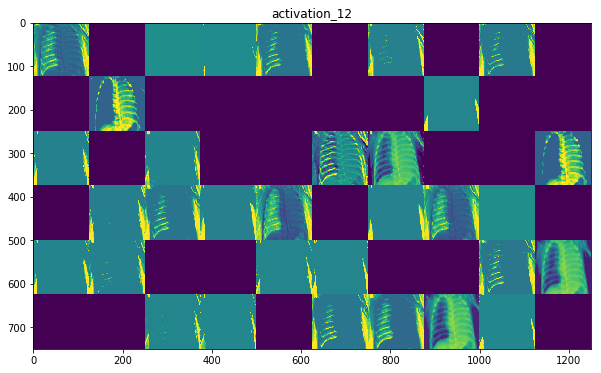

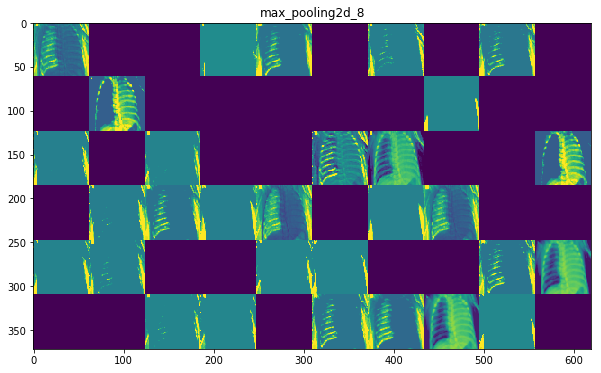

In [152]:
layer_names = []
for layer in cnn_1.layers[:6]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 10

for layer_name, layer_activation in zip(layer_names, activations[:6]): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

# https://towardsdatascience.com/visualizing-intermediate-activation-in-convolutional-neural-networks-with-keras-260b36d60d0    

-----

## Batch Normalization

In [39]:
# =========================================================
# define model
# =========================================================

## 1 - convolution block
cnn_1 = Sequential()
cnn_1.add(Conv2D(32, (3, 3), input_shape = input_shape))
cnn_1.add(Activation("relu"))
cnn_1.add(Conv2D(32, (3, 3), input_shape = input_shape))
cnn_1.add(Activation("relu"))
cnn_1.add(BatchNormalization())
cnn_1.add(MaxPooling2D(pool_size = (2, 2)))

## 2 - convolution block
cnn_1.add(Conv2D(32, (3, 3)))
cnn_1.add(Activation("relu"))
cnn_1.add(Conv2D(32, (3, 3)))
cnn_1.add(Activation("relu"))
cnn_1.add(MaxPooling2D(pool_size=(2, 2)))

## 3 - convolution block
cnn_1.add(Conv2D(64, (3, 3)))
cnn_1.add(Activation("relu"))
cnn_1.add(Conv2D(64, (3, 3)))
cnn_1.add(Activation("relu"))
cnn_1.add(MaxPooling2D(pool_size=(2, 2)))

## fully connected end
cnn_1.add(Flatten())
cnn_1.add(Dense(128))
cnn_1.add(Activation("relu"))
cnn_1.add(Dropout(0.5))
cnn_1.add(Dense(64))
cnn_1.add(Activation("relu"))
cnn_1.add(Dropout(0.25))
cnn_1.add(Dense(1))
cnn_1.add(Activation("sigmoid"))

# =========================================================
# re-compile model
# =========================================================

cnn_1.compile(loss = "binary_crossentropy",
              optimizer = optimizers.Adam(),
              metrics = ["acc"])

In [65]:
# =========================================================
# train model
# =========================================================

t0 = time.time()
cnn_1.fit_generator(train_generator,
                    epochs = 5,
                    validation_data = val_generator,
                    workers = cpus, 
                    use_multiprocessing = True)
t1 = time.time()

print("-----------------")
print(f"Time taken: {t1 - t0}")

Epoch 1/5
115/115 [==============================] - 46s 400ms/step - loss: 0.3723 - acc: 0.8437 - val_loss: 0.4600 - val_acc: 0.8444
Epoch 2/5
115/115 [==============================] - 43s 373ms/step - loss: 0.2521 - acc: 0.8999 - val_loss: 0.2587 - val_acc: 0.9001
Epoch 3/5
115/115 [==============================] - 43s 370ms/step - loss: 0.2250 - acc: 0.9117 - val_loss: 0.2580 - val_acc: 0.9077
Epoch 4/5
115/115 [==============================] - 42s 369ms/step - loss: 0.2334 - acc: 0.9212 - val_loss: 0.1636 - val_acc: 0.9367
Epoch 5/5
115/115 [==============================] - 43s 374ms/step - loss: 0.1846 - acc: 0.9372 - val_loss: 0.1463 - val_acc: 0.9507
-----------------
Time taken: 217.76399636268616


In [66]:
# generate predictions
cnn_1_pred = cnn_1.predict_generator(test_generator,
                                           workers = cpus,
                                           use_multiprocessing = True,
                                           verbose = True)
# convert to binary label
cnn_1_pred_label = [0 if x < 0.5 else 1 for x in list(cnn_1_pred)]

# true labels
labels = [0]*len(os.listdir(test_dir_neg)) + [1]*len(os.listdir(test_dir_pos))
accuracy_score(y_true = labels, y_pred = cnn_1_pred_label)

20/20 [==============================] - 4s 225ms/step


0.8189102564102564

In [67]:
print(classification_report(y_true = labels, y_pred = cnn_1_pred_label))

             precision    recall  f1-score   support

          0       0.96      0.54      0.69       234
          1       0.78      0.99      0.87       390

avg / total       0.85      0.82      0.80       624



----

## In-class exercise - add more batch normalization
### How does the model perform? 

In [64]:
# =========================================================
# define model
# =========================================================

#####
#### Write model here

# =========================================================
# re-compile model
# =========================================================

cnn_1.compile(loss = "binary_crossentropy",
              optimizer = optimizers.Adam(),
              metrics = ["acc"])

In [ ]:
# =========================================================
# train model
# =========================================================

t0 = time.time()
cnn_1.fit_generator(train_generator,
                    epochs = 5,
                    validation_data = val_generator,
                    workers = cpus, 
                    use_multiprocessing = True)
t1 = time.time()

print("-----------------")
print(f"Time taken: {t1 - t0}")

In [ ]:
# generate predictions
cnn_1_pred = cnn_1.predict_generator(test_generator,
                                           workers = cpus,
                                           use_multiprocessing = True,
                                           verbose = True)
# convert to binary label
cnn_1_pred_label = [0 if x < 0.5 else 1 for x in list(cnn_1_pred)]

# true labels
labels = [0]*len(os.listdir(test_dir_neg)) + [1]*len(os.listdir(test_dir_pos))
accuracy_score(y_true = labels, y_pred = cnn_1_pred_label)

In [ ]:
print(classification_report(y_true = labels, y_pred = cnn_1_pred_label))

----

# Transfer learning with VGG16

In [26]:
# =========================================================
# Import VGG19 model
# =========================================================

#vgg19 = VGG19(input_shape = input_shape, weights = "imagenet", include_top = False)

80142336/80134624 [==============================] - 1s 0us/step


In [27]:
# =========================================================
# Save model
# =========================================================

'''

# model to JSON file format
model_json = vgg19.to_json()
with open("data/x-pneumonia/VGG19.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
vgg19.save_weights("data/x-pneumonia/VGG19.h5")
print("vgg19 to disk")
'''



vgg19 to disk


In [25]:
# =========================================================
# Load VGG19 model from JSON
# =========================================================

# load json and create model
json_file = open("data/x-pneumonia/VGG19.json", "r")
vgg19_from_json = json_file.read()
json_file.close()

vgg19_base = model_from_json(vgg19_from_json)

In [26]:
# model summary
vgg19_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

## Can we recreate this model in Keras?

In [27]:
# ================================================
# Our VGG19
# ================================================

def MyVgg19(train_initial = False):
    img_input = Input(shape = input_shape)
    # Block 1 - convolutions
    vgg19x = Conv2D(filters = 64, kernel_size = (3, 3), padding = "same", activation = "relu",
                    name = "block1_conv1", trainable = train_initial)(img_input)
    vgg19x = Conv2D(filters = 64, kernel_size = (3, 3), padding = "same", activation = "relu",
                    name = "block1_conv2", trainable = train_initial)(vgg19x)
    vgg19x = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid",
                          name = "block1_pool", trainable = train_initial)(vgg19x)

    # Block 2 - convolutions
    vgg19x = Conv2D(filters = 128, kernel_size = (3, 3), padding = "same", activation = "relu",
                    name = "block2_conv1", trainable = train_initial)(vgg19x)
    vgg19x = Conv2D(filters = 128, kernel_size = (3, 3), padding = "same", activation = "relu",
                    name = "block2_conv2", trainable = train_initial)(vgg19x)
    vgg19x = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid",
                          name = "block2_pool", trainable = train_initial)(vgg19x)
    
    # Block 3 - convolutions
    vgg19x = Conv2D(filters = 256, kernel_size = (3, 3), padding = "same", activation = "relu",
                    name = "block3_conv1", trainable = train_initial)(vgg19x)
    vgg19x = Conv2D(filters = 256, kernel_size = (3, 3), padding = "same", activation = "relu",
                    name = "block3_conv2", trainable = train_initial)(vgg19x)
    vgg19x = Conv2D(filters = 256, kernel_size = (3, 3), padding = "same", activation = "relu",
                    name = "block3_conv3", trainable = train_initial)(vgg19x)
    vgg19x = Conv2D(filters = 256, kernel_size = (3, 3), padding = "same", activation = "relu",
                    name = "block3_conv4", trainable = train_initial)(vgg19x)
    vgg19x = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid",
                          name = "block3_pool", trainable = train_initial)(vgg19x)
    
    # Block 4 - convolutions
    vgg19x = Conv2D(filters = 512, kernel_size = (3, 3), padding = "same", activation = "relu",
                    name = "block4_conv1", trainable = train_initial)(vgg19x)
    vgg19x = Conv2D(filters = 512, kernel_size = (3, 3), padding = "same", activation = "relu",
                    name = "block4_conv2", trainable = train_initial)(vgg19x)
    vgg19x = Conv2D(filters = 512, kernel_size = (3, 3), padding = "same", activation = "relu",
                    name = "block4_conv3", trainable = train_initial)(vgg19x)
    vgg19x = Conv2D(filters = 512, kernel_size = (3, 3), padding = "same", activation = "relu",
                    name = "block4_conv4", trainable = train_initial)(vgg19x)
    vgg19x = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid",
                          name = "block4_pool", trainable = train_initial)(vgg19x)
    
    # Block 4 - convolutions
    vgg19x = Conv2D(filters = 512, kernel_size = (3, 3), padding = "same", activation = "relu",
                    name = "block5_conv1", trainable = train_initial)(vgg19x)
    vgg19x = Conv2D(filters = 512, kernel_size = (3, 3), padding = "same", activation = "relu",
                    name = "block5_conv2", trainable = train_initial)(vgg19x)
    vgg19x = Conv2D(filters = 512, kernel_size = (3, 3), padding = "same", activation = "relu",
                    name = "block5_conv3", trainable = train_initial)(vgg19x)
    vgg19x = Conv2D(filters = 512, kernel_size = (3, 3), padding = "same", activation = "relu",
                    name = "block5_conv4", trainable = train_initial)(vgg19x)
    vgg19x = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid",
                          name = "block5_pool", trainable = train_initial)(vgg19x)

    # final layers
    vgg19x = Flatten(name = "flatten")(vgg19x)
    vgg19x = Dense(1024, activation = "relu", name = "fc1")(vgg19x)
    vgg19x = Dropout(0.4, name = "dropout_1")(vgg19x)
    vgg19x = Dense(256, activation = "relu", name = "fc2")(vgg19x)
    vgg19x = Dropout(0.2, name = "dropout_2")(vgg19x)
    vgg19x = Dense(1, activation = "sigmoid", name = "final_prediction")(vgg19x)
    
    # complete model
    model = Model(inputs = img_input, outputs = vgg19x)
    return model 

In [28]:
# create VGG19 model
vgg19_model = MyVgg19(train_initial = False)
vgg19_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

## Transferring weights

In [29]:
# vgg layers
vgg19_base.layers

In [30]:
# vgg weights
vgg19_base.layers[1].get_weights()

[array([[[[-0.06015392,  0.07783259, -0.03451299, ..., -0.06364003,
            0.02491774, -0.01697408],
          [ 0.06538308, -0.01839313, -0.02570705, ..., -0.02966481,
           -0.04443144,  0.0188942 ],
          [ 0.05499826, -0.0296758 ,  0.09117921, ..., -0.03748756,
            0.01539121,  0.07098237]],
 
         [[-0.05543175,  0.06131448, -0.00354418, ..., -0.08413029,
           -0.05423418, -0.04123813],
          [ 0.0815043 ,  0.07250549, -0.00406143, ...,  0.03900683,
            0.07264924,  0.03553164],
          [-0.01516204,  0.06557114,  0.08976866, ..., -0.08473958,
           -0.06572364, -0.0552056 ]],
 
         [[ 0.09597026,  0.00286745,  0.07738085, ...,  0.0635269 ,
           -0.01155219, -0.01356762],
          [-0.06891201, -0.02352396,  0.0740454 , ..., -0.04055167,
            0.09419991,  0.04264806],
          [-0.08870821,  0.09888804, -0.09431507, ..., -0.03095555,
            0.03828919, -0.08479913]]],
 
 
        [[[-0.07267144,  0.0689237

In [31]:
vgg19_base.layers[1].get_weights()[0].shape

(3, 3, 3, 64)

### The initial weights are random

In [32]:
# first load VGG weights
vgg19_base.load_weights("data/x-pneumonia/VGG19.h5")

In [33]:
vgg19_base.layers[1].get_weights()[0]

array([[[[ 0.34119523,  0.09563112,  0.0177449 , ..., -0.11436455,
          -0.05099866, -0.00299793],
         [ 0.46418372,  0.03355668,  0.10245045, ..., -0.06945956,
          -0.04020201,  0.04048637],
         [ 0.39416704, -0.08419707, -0.03631314, ..., -0.10720515,
          -0.03804016,  0.04690642]],

        [[ 0.33999205,  0.13363543,  0.02129423, ..., -0.13025227,
          -0.16508926, -0.06969624],
         [ 0.41810837,  0.05260524,  0.09755926, ..., -0.09385028,
          -0.20492788, -0.0573062 ],
         [ 0.37740308, -0.07876257, -0.04775979, ..., -0.11827433,
          -0.19008617, -0.01889699]],

        [[-0.04484424,  0.06471398, -0.07631404, ..., -0.12629718,
          -0.29905206, -0.2825364 ],
         [-0.04806903, -0.00658076, -0.02234544, ..., -0.0878844 ,
          -0.3915486 , -0.34632796],
         [-0.04594866, -0.11583115, -0.14462094, ..., -0.12290562,
          -0.35782176, -0.27979308]]],


       [[[ 0.23215917,  0.133657  ,  0.12134422, ..., -0

In [34]:
# what about our model?
print(vgg19_model.layers[1].get_weights()[0].shape)
vgg19_model.layers[1].get_weights()

(3, 3, 3, 64)


[array([[[[-0.08312406, -0.03916349,  0.00022655, ...,  0.07417074,
            0.03499655, -0.08215474],
          [ 0.0991133 ,  0.07267615,  0.07513776, ...,  0.01513671,
            0.03224711,  0.04345575],
          [-0.08557261, -0.04423805, -0.0275305 , ...,  0.08212657,
           -0.0087072 , -0.02577914]],
 
         [[ 0.00923034,  0.06798896, -0.08242783, ...,  0.09335987,
            0.05349186,  0.09603094],
          [-0.00842483, -0.02457819, -0.06149209, ..., -0.00963112,
            0.08967519,  0.03191768],
          [-0.08442299, -0.07123265, -0.01974469, ..., -0.07634713,
            0.08914621, -0.08659033]],
 
         [[ 0.01928576, -0.01122291, -0.02438729, ...,  0.0351861 ,
           -0.07780473, -0.09850923],
          [ 0.01935116, -0.06154722, -0.08153834, ...,  0.01841404,
            0.00514115, -0.0079536 ],
          [ 0.05163346,  0.08936864,  0.08612153, ..., -0.0858032 ,
            0.02832198,  0.03437957]]],
 
 
        [[[ 0.01871022,  0.0260340

In [35]:
# add weights from pre-trained VGG to our VGG
cnt = 0
for layer in vgg19_model.layers:
    if layer.name[:6] in ["block1", "block2", "block3", "block4", "block5"]:
        print(layer.name)
        vgg19_model.layers[cnt].set_weights(vgg19_base.layers[cnt].get_weights())
    cnt += 1

block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [36]:
# updated weights
vgg19_model.layers[1].get_weights()

[array([[[[ 0.34119523,  0.09563112,  0.0177449 , ..., -0.11436455,
           -0.05099866, -0.00299793],
          [ 0.46418372,  0.03355668,  0.10245045, ..., -0.06945956,
           -0.04020201,  0.04048637],
          [ 0.39416704, -0.08419707, -0.03631314, ..., -0.10720515,
           -0.03804016,  0.04690642]],
 
         [[ 0.33999205,  0.13363543,  0.02129423, ..., -0.13025227,
           -0.16508926, -0.06969624],
          [ 0.41810837,  0.05260524,  0.09755926, ..., -0.09385028,
           -0.20492788, -0.0573062 ],
          [ 0.37740308, -0.07876257, -0.04775979, ..., -0.11827433,
           -0.19008617, -0.01889699]],
 
         [[-0.04484424,  0.06471398, -0.07631404, ..., -0.12629718,
           -0.29905206, -0.2825364 ],
          [-0.04806903, -0.00658076, -0.02234544, ..., -0.0878844 ,
           -0.3915486 , -0.34632796],
          [-0.04594866, -0.11583115, -0.14462094, ..., -0.12290562,
           -0.35782176, -0.27979308]]],
 
 
        [[[ 0.23215917,  0.133657 

In [37]:
del vgg19_base

In [38]:
# compile model
vgg19_model.compile(loss = "binary_crossentropy", 
                    optimizer = optimizers.SGD(lr = 0.001, momentum = 0.9),
                    metrics = ["accuracy"])

In [39]:
# =========================================================
# model input parameters
# =========================================================
image_width = 256
image_height = 256
image_size = (image_width, image_height)
input_shape = (image_width, image_height, 3)
batch_size = 32

In [40]:
# =========================================================
# image batch generator
# =========================================================

# train generator
train_datagen = ImageDataGenerator(rescale = 1./255, 
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# test generator
test_datagen = ImageDataGenerator(rescale = 1./255)

# data paths for the generators
train_generator = train_datagen.flow_from_directory(directory = train_dir, 
                                                    target_size = image_size, 
                                                    batch_size = batch_size,
                                                    shuffle = True,
                                                    class_mode = "binary")

val_generator = test_datagen.flow_from_directory(directory = val_dir, 
                                                    target_size = image_size, 
                                                    batch_size = batch_size,
                                                    shuffle = False,
                                                    class_mode = "binary")

test_generator = test_datagen.flow_from_directory(directory = test_dir, 
                                                    target_size = image_size, 
                                                    batch_size = batch_size,
                                                    shuffle = False,
                                                    class_mode = "binary")

Found 3651 images belonging to 2 classes.
Found 1581 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [41]:
# =================================================
# train model
# =================================================
t0 = time.time()
hist = vgg19_model.fit_generator(train_generator,
                    epochs = 3,
                    validation_data = val_generator,
                    workers = cpus, 
                    use_multiprocessing = True)
t1 = time.time()
print(t1 - t0)

Epoch 1/3
115/115 [==============================] - 80s 699ms/step - loss: 0.3905 - acc: 0.8224 - val_loss: 0.2169 - val_acc: 0.9133
Epoch 2/3
115/115 [==============================] - 73s 639ms/step - loss: 0.2583 - acc: 0.8929 - val_loss: 0.1850 - val_acc: 0.9254
Epoch 3/3
115/115 [==============================] - 74s 641ms/step - loss: 0.2401 - acc: 0.9015 - val_loss: 0.2539 - val_acc: 0.8937
227.8763198852539


In [42]:
# generate predictions
vgg19_pred = vgg19_model.predict_generator(test_generator,
                                           workers = cpus,
                                           use_multiprocessing = True,
                                           verbose = True)
# convert to binary label
vgg19_pred_label = [0 if x < 0.5 else 1 for x in list(vgg19_pred)]

# true labels
labels = [0]*len(os.listdir(test_dir_neg)) + [1]*len(os.listdir(test_dir_pos))
accuracy_score(y_true = labels, y_pred = vgg19_pred_label)

20/20 [==============================] - 12s 577ms/step


0.8669871794871795

In [43]:
print(classification_report(y_true = labels, y_pred = vgg19_pred_label))

             precision    recall  f1-score   support

          0       0.85      0.78      0.81       234
          1       0.87      0.92      0.90       390

avg / total       0.87      0.87      0.87       624



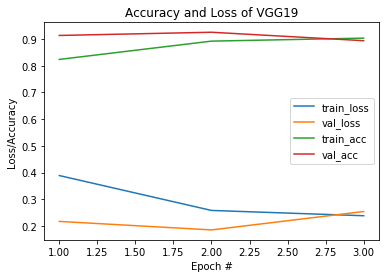

In [51]:
num_epochs = 4
plt.figure()
plt.plot(np.arange(1, num_epochs, step = 1), hist.history["loss"], label = "train_loss")
plt.plot(np.arange(1, num_epochs, step = 1), hist.history["val_loss"], label = "val_loss")
plt.plot(np.arange(1, num_epochs, step = 1), hist.history["acc"], label = "train_acc")
plt.plot(np.arange(1, num_epochs, step = 1), hist.history["val_acc"], label = "val_acc")
plt.title("Accuracy and Loss of VGG19")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc = "center right");

-----

# In-class exercise 

## Train the last convolutional block of VGG19

In [53]:
# ================================================
# Our VGG19
# ================================================

def MyVgg19(train_initial = False):
    img_input = Input(shape = input_shape)
    # Block 1 - convolutions
    vgg19x = Conv2D(filters = 64, kernel_size = (3, 3), padding = "same", activation = "relu",
                    name = "block1_conv1", trainable = train_initial)(img_input)
    vgg19x = Conv2D(filters = 64, kernel_size = (3, 3), padding = "same", activation = "relu",
                    name = "block1_conv2", trainable = train_initial)(vgg19x)
    vgg19x = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid",
                          name = "block1_pool", trainable = train_initial)(vgg19x)

    # Block 2 - convolutions
    vgg19x = Conv2D(filters = 128, kernel_size = (3, 3), padding = "same", activation = "relu",
                    name = "block2_conv1", trainable = train_initial)(vgg19x)
    vgg19x = Conv2D(filters = 128, kernel_size = (3, 3), padding = "same", activation = "relu",
                    name = "block2_conv2", trainable = train_initial)(vgg19x)
    vgg19x = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid",
                          name = "block2_pool", trainable = train_initial)(vgg19x)
    
    # Block 3 - convolutions
    vgg19x = Conv2D(filters = 256, kernel_size = (3, 3), padding = "same", activation = "relu",
                    name = "block3_conv1", trainable = train_initial)(vgg19x)
    vgg19x = Conv2D(filters = 256, kernel_size = (3, 3), padding = "same", activation = "relu",
                    name = "block3_conv2", trainable = train_initial)(vgg19x)
    vgg19x = Conv2D(filters = 256, kernel_size = (3, 3), padding = "same", activation = "relu",
                    name = "block3_conv3", trainable = train_initial)(vgg19x)
    vgg19x = Conv2D(filters = 256, kernel_size = (3, 3), padding = "same", activation = "relu",
                    name = "block3_conv4", trainable = train_initial)(vgg19x)
    vgg19x = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid",
                          name = "block3_pool", trainable = train_initial)(vgg19x)
    
    # Block 4 - convolutions
    vgg19x = Conv2D(filters = 512, kernel_size = (3, 3), padding = "same", activation = "relu",
                    name = "block4_conv1", trainable = train_initial)(vgg19x)
    vgg19x = Conv2D(filters = 512, kernel_size = (3, 3), padding = "same", activation = "relu",
                    name = "block4_conv2", trainable = train_initial)(vgg19x)
    vgg19x = Conv2D(filters = 512, kernel_size = (3, 3), padding = "same", activation = "relu",
                    name = "block4_conv3", trainable = train_initial)(vgg19x)
    vgg19x = Conv2D(filters = 512, kernel_size = (3, 3), padding = "same", activation = "relu",
                    name = "block4_conv4", trainable = train_initial)(vgg19x)
    vgg19x = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid",
                          name = "block4_pool", trainable = train_initial)(vgg19x)
    
    # Block 4 - convolutions
    vgg19x = Conv2D(filters = 512, kernel_size = (3, 3), padding = "same", activation = "relu",
                    name = "block5_conv1", trainable = True)(vgg19x)
    vgg19x = Conv2D(filters = 512, kernel_size = (3, 3), padding = "same", activation = "relu",
                    name = "block5_conv2", trainable = True)(vgg19x)
    vgg19x = Conv2D(filters = 512, kernel_size = (3, 3), padding = "same", activation = "relu",
                    name = "block5_conv3", trainable = True)(vgg19x)
    vgg19x = Conv2D(filters = 512, kernel_size = (3, 3), padding = "same", activation = "relu",
                    name = "block5_conv4", trainable = True)(vgg19x)
    vgg19x = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid",
                          name = "block5_pool", trainable = True)(vgg19x)

    # final layers
    vgg19x = Flatten(name = "flatten")(vgg19x)
    vgg19x = Dense(1024, activation = "relu", name = "fc1")(vgg19x)
    vgg19x = Dropout(0.4, name = "dropout_1")(vgg19x)
    vgg19x = Dense(256, activation = "relu", name = "fc2")(vgg19x)
    vgg19x = Dropout(0.2, name = "dropout_2")(vgg19x)
    vgg19x = Dense(1, activation = "sigmoid", name = "final_prediction")(vgg19x)
    
    # complete model
    model = Model(inputs = img_input, outputs = vgg19x)
    return model 

In [54]:
# create VGG19 model
vgg19_model = MyVgg19(train_initial = False)
vgg19_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [55]:
# =========================================================
# Load VGG19 model from JSON
# =========================================================

# load json and create model
json_file = open("data/x-pneumonia/VGG19.json", "r")
vgg19_from_json = json_file.read()
json_file.close()

vgg19_base = model_from_json(vgg19_from_json)
vgg19_base.load_weights("data/x-pneumonia/VGG19.h5")

In [56]:
# add weights from pre-trained VGG to our VGG
cnt = 0
for layer in vgg19_model.layers:
    if layer.name[:6] in ["block1", "block2", "block3", "block4"]:
        print(layer.name)
        vgg19_model.layers[cnt].set_weights(vgg19_base.layers[cnt].get_weights())
    cnt += 1

block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool


In [57]:
# compile model
vgg19_model.compile(loss = "binary_crossentropy", 
                    optimizer = optimizers.SGD(lr = 0.001, momentum = 0.9),
                    metrics = ["accuracy"])

In [58]:
del vgg19_base

In [59]:
# =================================================
# train model
# =================================================
t0 = time.time()
hist = vgg19_model.fit_generator(train_generator,
                    epochs = 3,
                    validation_data = val_generator,
                    workers = cpus, 
                    use_multiprocessing = True)
t1 = time.time()
print(t1 - t0)

Epoch 1/3
115/115 [==============================] - 83s 718ms/step - loss: 0.3778 - acc: 0.8446 - val_loss: 0.1364 - val_acc: 0.9507
Epoch 2/3
115/115 [==============================] - 80s 694ms/step - loss: 0.1724 - acc: 0.9340 - val_loss: 0.1081 - val_acc: 0.9570
Epoch 3/3
115/115 [==============================] - 80s 698ms/step - loss: 0.1262 - acc: 0.9497 - val_loss: 0.1119 - val_acc: 0.9551
242.93814373016357


In [60]:
# generate predictions
vgg19_pred = vgg19_model.predict_generator(test_generator,
                                           workers = cpus,
                                           use_multiprocessing = True,
                                           verbose = True)
# convert to binary label
vgg19_pred_label = [0 if x < 0.5 else 1 for x in list(vgg19_pred)]

# true labels
labels = [0]*len(os.listdir(test_dir_neg)) + [1]*len(os.listdir(test_dir_pos))
accuracy_score(y_true = labels, y_pred = vgg19_pred_label)

20/20 [==============================] - 10s 501ms/step


0.8717948717948718

In [61]:
print(classification_report(y_true = labels, y_pred = vgg19_pred_label))

             precision    recall  f1-score   support

          0       0.96      0.68      0.80       234
          1       0.84      0.98      0.91       390

avg / total       0.89      0.87      0.87       624



----